# Business Questions

What problem are you trying to solve? 

- Improve customer retention and customize our marketing strategies to increase sales.

What value will this project bring? 

- This customer clustering project will allow us to identify groups of customers with similar behaviors and preferences. This will help us design more effective marketing strategies and offer personalized promotions, which should result in increased sales and customer retention.

Question 1: Which are the most relevant features that can influence client segmentation?

Analyze the distribution and variability of characteristics such as Quantity, UnitPrice, and explore whether they have an impact on customer segmentation.

Question 2: Are there any recurring buying patterns or trends in customer buying behavior?

Use time series analysis techniques to identify recurring purchase patterns based on the InvoiceDate column.

Question 3: Are there natural groups of products based on characteristics such as code (StockCode) and description (Description)?

Apply clustering techniques to explore whether there are natural groups of products in the data.

# Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans

# Data Preparation and Cleaning

In [10]:
# load dataset
customers_df = pd.read_excel('Online Retail.xlsx')

In [11]:
# Visualize the first five rows to get an initial understanding of the data
customers_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
# Get information about each column data type and check for null values
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Description and CustomerID columns seem to have some missing values.

For the Description column, I will fill in the missing values with 'Unknown' value since I consider 
it vital for the context of the project because it is describing the products of the online retail.

In [15]:
customers_df['Description'].fillna('Unknown', inplace=True)

Now, the Description column should have 541909 values

In [17]:
def verify_nulls(dataframe, column):
    """
    Verify if one column of the dataframe has null values
    
    Args:
        dataframe (pd.DataFrame): The DataFrame.
        column (str): Name of the column to verify.
        
    Returns:
        int: Number of null values in the column.
    """
    null_values = dataframe[column].isnull()
    null_quantity = null_values.sum()
    
    return null_quantity

In [18]:
verify_nulls(customers_df,'Description')

0

The code worked and column Description has now 0 null values. 

Now, let's tackle CustomerID column. I will first check the percentage of missing values this column represents, to then make a decision about it.

In [21]:
def percentage_missing_values(dataframe, column):
    total_rows=len(dataframe)
    missing_values=dataframe[column].isnull().sum()
    percentage = (missing_values / total_rows) * 100
    return percentage

In [22]:
percentage_mv_CustomerID = percentage_missing_values(customers_df, 'CustomerID')
print(f'The missing values percentage in column "CustomerID" is: {percentage_mv_CustomerID}%')

The missing values percentage in column "CustomerID" is: 24.926694334288598%


Since we have a quarter of the values missing in CustomerID column, I will assign unique identifiers to them

In [24]:
# Create a new column 'NewCustomerID' with unique identifiers

customers_df['NewCustomerID'] = np.where(customers_df['CustomerID'].isnull(), np.arange(len(customers_df)), customers_df['CustomerID'])

This column will have unique identifiers for all records. Thus, I will keep working with this column and 
drop CustomerID one.

In [26]:
customers_df.drop(columns=['CustomerID'], inplace=True)

# Check that 'NewCustomerID' column does not have missing values:

verify_nulls(customers_df, 'NewCustomerID')

0

Now that I have managed the missing values in columns 'Description' and 'CustomerID' as a new column 'NewCustomerID' I will inspect again for a final check that there are no more missing values.

In [28]:
customers_df.isnull().sum()

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
InvoiceDate      0
UnitPrice        0
Country          0
NewCustomerID    0
dtype: int64

We do not have missing values now !

In [30]:
# Final revision of the columns
customers_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country', 'NewCustomerID'],
      dtype='object')

# EDA

In [32]:
# Calculate descriptive statistics such as mean, median, standard deviation, minimum 
# and maximum for each of these characteristics. 
# This will give you an idea of the distribution and variability of the data.

# Estadísticas descriptivas para 'Quantity' y 'UnitPrice'
print(customers_df[['Quantity', 'UnitPrice']].describe())

            Quantity      UnitPrice
count  541909.000000  541909.000000
mean        9.552250       4.611114
std       218.081158      96.759853
min    -80995.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   38970.000000


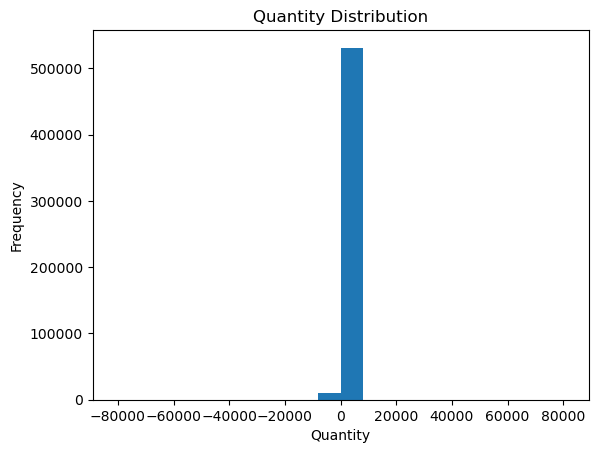

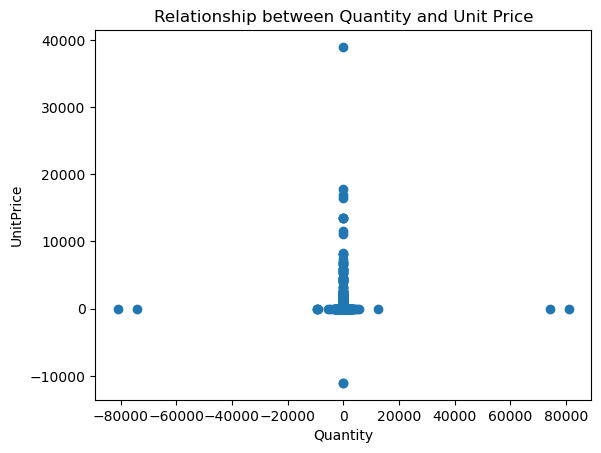

In [33]:
#'Quantity' Histogram
plt.hist(customers_df['Quantity'], bins=20)
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.title('Quantity Distribution')
plt.show()

# 'Quantity' vs 'UnitPrice' scatter plot
plt.scatter(customers_df['Quantity'], customers_df['UnitPrice'])
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.title('Relationship between Quantity and Unit Price')
plt.show()

# Preprocessing and Feature Engineering

Normalization and Standarization

In [36]:
# Given that 'Quantity' and 'UnitPrice' have different scales, I am going to standardixe them so they have an 
# equal currency in the clustering.

scaler = StandardScaler()
customers_df[['Quantity', 'UnitPrice']] = scaler.fit_transform(customers_df[['Quantity', 'UnitPrice']])

Encode categorical columns

In [38]:
# For column 'Country' I will check how many distinct values it has, to then decide whether I perform one hot 
# encoding or other technique

def distinct_values(customers_df, column):
    quantity_distinct=customers_df[column].nunique()
    distinct=customers_df[column].unique()
    return quantity_distinct, distinct

distinct_values(customers_df, 'Country')

(38,
 array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
        'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
        'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
        'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
        'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
        'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
        'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
        'European Community', 'Malta', 'RSA'], dtype=object))

Given that we have 38 countries, I will identify the N most common countries and create a column for each of them. The rest of the countries will be grouped in a category called 'Other'. This technique is useful if there are some countries that are much more common than others.

In [40]:
# Identify the N most common countries
top_countries = customers_df['Country'].value_counts().nlargest(5).index.tolist()

# Create columns for most common countries
for country in top_countries:
    customers_df[f'Country_{country}'] = (customers_df['Country'] == country).astype(int)

# Create column 'Country_Others' for the rest of the countries
customers_df['Country_Others'] = customers_df['Country'].apply(lambda x: 1 if x not in top_countries else 0)


In [41]:
#To verify if it worked, we can:

# Revise the added columns and use customers_df.head() to inspect the first rows of the dataframe
# with the new columns.

customers_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,NewCustomerID,Country_United Kingdom,Country_Germany,Country_France,Country_EIRE,Country_Spain,Country_Others
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.016289,2010-12-01 08:26:00,-0.021301,United Kingdom,17850.0,1,0,0,0,0,0
1,536365,71053,WHITE METAL LANTERN,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.007118,2010-12-01 08:26:00,-0.019234,United Kingdom,17850.0,1,0,0,0,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0


In [60]:
#Check the encoding logic:

#For a specific country, let's verify if the encoding is performed correctly. 

#For example, if we select a common country and a less common country, you can check whether the corresponding column
#is set to 1 or 0 as appropriate.

# Check a common country
print(customers_df[['Country_United Kingdom', 'Country_Others']].head())

# Check a less common country
print(customers_df[['Country_Germany', 'Country_Others']].head())

   Country_United Kingdom  Country_Others
0                       1               0
1                       1               0
2                       1               0
3                       1               0
4                       1               0
   Country_Germany  Country_Others
0                0               0
1                0               0
2                0               0
3                0               0
4                0               0


In [62]:
#Sum of Coding Columns:

#If we sum the coding columns for a client, the total should be 1. 
# (Since it will belong to one and only one of the groups).

total_encoding = customers_df[['Country_United Kingdom', 'Country_Germany', 'Country_France', 'Country_Others']].sum(axis=1)
print(total_encoding.value_counts())

1    531180
0     10729
dtype: int64


Time Series Analysis:
Given that we are interested in recurring purchase patterns, I will convert the InvoiceDate column to date and time format and extract relevant features such as day of the week and time.

In [65]:
customers_df['InvoiceDate'] = pd.to_datetime(customers_df['InvoiceDate'])
customers_df['Weekday'] = customers_df['InvoiceDate'].dt.dayofweek
customers_df['Hour'] = customers_df['InvoiceDate'].dt.hour

In [67]:
# Now, to verify if this transformation was successful and if it provides useful information about customer buying behavior, we can follow these steps:
    
# Check the New Columns:
# Let's verify that the new columns ('Weekday' and 'Hour') have been correctly added to the DataFrame. 

customers_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,NewCustomerID,Country_United Kingdom,Country_Germany,Country_France,Country_EIRE,Country_Spain,Country_Others,Weekday,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.016289,2010-12-01 08:26:00,-0.021301,United Kingdom,17850.0,1,0,0,0,0,0,2,8
1,536365,71053,WHITE METAL LANTERN,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.007118,2010-12-01 08:26:00,-0.019234,United Kingdom,17850.0,1,0,0,0,0,0,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0,2,8


In [69]:
#Explore Trends:

# Perform some exploratory analysis to identify trends in purchases based on days of the week ('Weekday') and hours of the day ('Hour'). 
total_purchases_by_weekday = customers_df.groupby('Weekday')['Quantity'].sum()
total_purchases_by_hour = customers_df.groupby('Hour')['Quantity'].sum()

print(total_purchases_by_weekday)
print(total_purchases_by_hour)

Weekday
0   -427.226697
1    -50.221817
2    303.784074
3    805.916397
4     42.699524
6   -674.951481
Name: Quantity, dtype: float64
Hour
6      -2.190206
7      53.661212
8     335.022415
9     465.048256
10    990.468596
11    397.813550
12    330.551514
13    -61.596392
14   -334.512606
15   -599.643521
16   -955.761748
17   -531.885425
18    -71.325063
19    -15.412096
20     -0.238486
Name: Quantity, dtype: float64


The results obtained indicate the total amount of purchases (in terms of quantity of products) for each day of the week and for each hour of the day.

For the column 'Weekday':

Negative values indicate that more products were returned than were purchased on that day of the week.
Positive values indicate that more products were purchased than were returned on that weekday.
For example, for the first day of the week (Monday), more products have been returned than have been purchased in total.

For the column 'Hour':

Positive values indicate that more products were purchased at that hour of the day compared to the number of products returned.
Negative values indicate that more products were returned at that hour of the day compared to the number of products purchased.
For example, for the sixth hour of the day (6 AM), more products were returned than were purchased in total.
These results suggest that there is some variation in product purchase and return behavior by day of the week and time of day. It may be useful to further investigate these trends to better understand customer behavior and how they may influence segmentation.

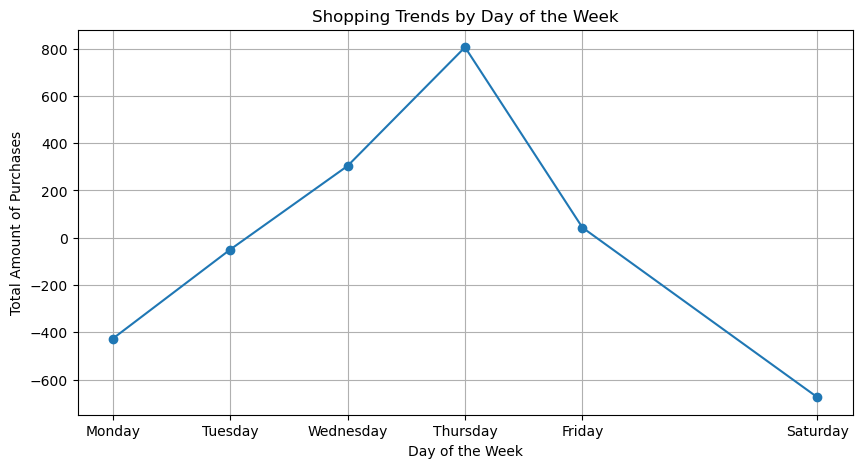

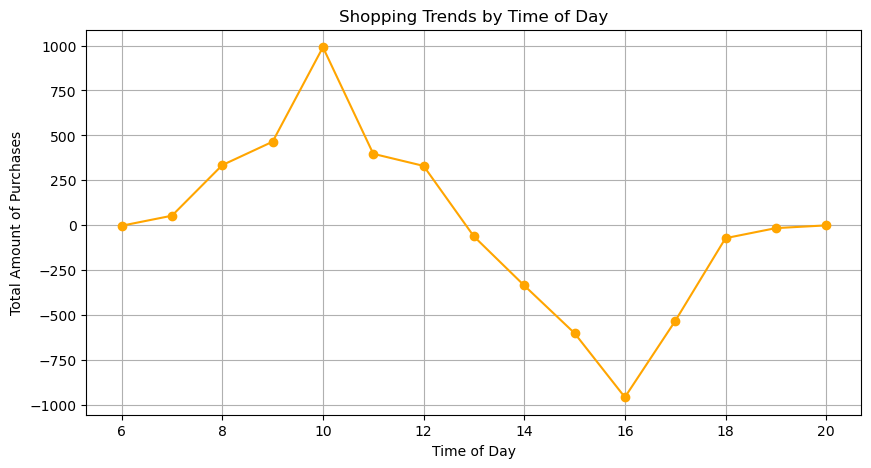

In [73]:
# Line chart for trends by day of the week
plt.figure(figsize=(10, 5))
plt.plot(total_purchases_by_weekday.index, total_purchases_by_weekday.values, marker='o')
plt.title('Shopping Trends by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Amount of Purchases')
plt.xticks(total_purchases_by_weekday.index, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.grid(True)
plt.show()

# Line chart for trends by time of day
plt.figure(figsize=(10, 5))
plt.plot(total_purchases_by_hour.index, total_purchases_by_hour.values, marker='o', color='orange')
plt.title('Shopping Trends by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Amount of Purchases')
plt.grid(True)
plt.show()


/tmp/ipykernel_538/2082954678.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = customers_df.corr()


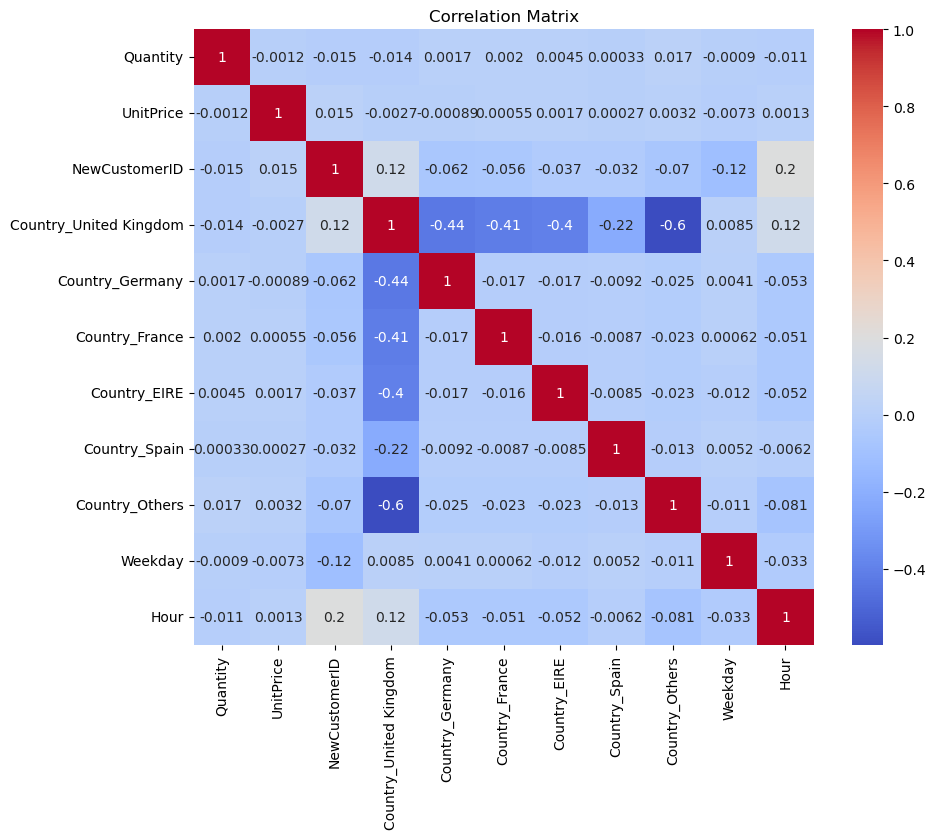

In [77]:
# Calculate the correlation matrix
correlation_matrix = customers_df.corr()

# Create a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [79]:
correlation_matrix = customers_df.corr()
print(correlation_matrix)

/tmp/ipykernel_538/822059129.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = customers_df.corr()


                        Quantity  UnitPrice  NewCustomerID  \
Quantity                1.000000  -0.001235      -0.015367   
UnitPrice              -0.001235   1.000000       0.014522   
NewCustomerID          -0.015367   0.014522       1.000000   
Country_United Kingdom -0.014182  -0.002657       0.122377   
Country_Germany         0.001725  -0.000889      -0.062376   
Country_France          0.001951   0.000547      -0.056285   
Country_EIRE            0.004461   0.001665      -0.036812   
Country_Spain           0.000326   0.000267      -0.031873   
Country_Others          0.016524   0.003215      -0.069770   
Weekday                -0.000904  -0.007310      -0.115955   
Hour                   -0.011268   0.001268       0.198264   

                        Country_United Kingdom  Country_Germany  \
Quantity                             -0.014182         0.001725   
UnitPrice                            -0.002657        -0.000889   
NewCustomerID                         0.122377        

# Predictions - Clustering

In [81]:
# Step 1: Data standardization.

# Before applying any clustering technique, it is important to standardize the data so that all features have the same scale. This is especially important when variables have different units or magnitudes. We will use Z-standardization, which transforms the variables so that they have a mean of 0 and a standard deviation of 1.

# Select only the columns relevant for clustering.
columns_for_clustering = ['Quantity', 'UnitPrice', 'NewCustomerID', 'Country_United Kingdom', 'Country_Germany', 
                           'Country_France', 'Country_EIRE', 'Country_Spain', 'Country_Others', 'Weekday', 'Hour']

# Standardize data
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(customers_df[columns_for_clustering])

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

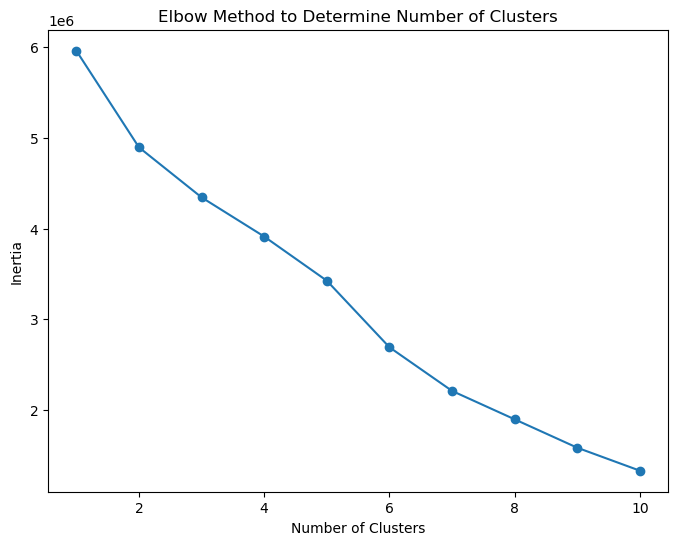

In [85]:
# Step 2: Choosing the number of clusters.

# Before applying a clustering algorithm, we need to determine how many clusters we want in our model. We can use techniques such as the Elbow Method or the Silhouette Method to make this decision. In this case, we will use the Elbow Method.


# Find the optimal number of clusters using the Elbow Method.
inertia_values = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Number of Clusters')
plt.show()

In [87]:
# Step 3: Application of the clustering algorithm

# Choose the optimal number of clusters for 4 clusters
optimal_n_clusters_4 = 4

# Apply the clustering algorithm for 4 clusters
kmeans_4 = KMeans(n_clusters=optimal_n_clusters_4, random_state=0)
clusters_4 = kmeans_4.fit_predict(scaled_data)

# Add the clustering results to the DataFrame for 4 clusters
customers_df['Cluster_4'] = clusters_4

# Choose the optimal number of clusters for 6 clusters
optimal_n_clusters_6 = 6

# Apply the clustering algorithm for 6 clusters
kmeans_6 = KMeans(n_clusters=optimal_n_clusters_6, random_state=0)
clusters_6 = kmeans_6.fit_predict(scaled_data)

# Add the clustering results to the DataFrame for 6 clusters
customers_df['Cluster_6'] = clusters_6

customers_df

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,NewCustomerID,Country_United Kingdom,Country_Germany,Country_France,Country_EIRE,Country_Spain,Country_Others,Weekday,Hour,Cluster_4,Cluster_6
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.016289,2010-12-01 08:26:00,-0.021301,United Kingdom,17850.0,1,0,0,0,0,0,2,8,0,1
1,536365,71053,WHITE METAL LANTERN,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0,2,8,0,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.007118,2010-12-01 08:26:00,-0.019234,United Kingdom,17850.0,1,0,0,0,0,0,2,8,0,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0,2,8,0,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.016289,2010-12-01 08:26:00,-0.012620,United Kingdom,17850.0,1,0,0,0,0,0,2,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,0.011224,2011-12-09 12:50:00,-0.038871,France,12680.0,0,0,1,0,0,0,4,12,2,4
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,-0.016289,2011-12-09 12:50:00,-0.025952,France,12680.0,0,0,1,0,0,0,4,12,2,4
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,-0.025460,2011-12-09 12:50:00,-0.004766,France,12680.0,0,0,1,0,0,0,4,12,2,4
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,-0.025460,2011-12-09 12:50:00,-0.004766,France,12680.0,0,0,1,0,0,0,4,12,2,4


# Conclutions

In [89]:
# Interpretation of the Results for 4 Clusters:
# First, let's look at how to interpret the clusters in terms of customer behavior.

# Number of customers in each cluster
customers_df['Cluster_4'].value_counts()

0    506205
3     17652
1      9495
2      8557
Name: Cluster_4, dtype: int64

In [93]:
# Let's examine the average characteristics of each cluster, especially the columns that were standardized (Quantity and UnitPrice). This will give an idea of trends in buying behavior.

cluster_means = customers_df.groupby('Cluster_4')[['Quantity', 'UnitPrice']].mean()

In [95]:
# We can also explore the distribution of other categorical features (such as 'Weekday', 'Hour' or 'Country') in each cluster.

weekday_distribution = customers_df.groupby(['Cluster_4', 'Weekday']).size().unstack().fillna(0)
hour_distribution = customers_df.groupby(['Cluster_4', 'Hour']).size().unstack().fillna(0)
country_distribution = customers_df.groupby(['Cluster_4', 'Country']).size().unstack().fillna(0)

Interpretation of the Results for 6 Clusters

In [97]:
# We can follow the same steps to interpret the results for all 6 clusters. 

# Number of customers in each cluster
customers_df['Cluster_6'].value_counts()

# Average characteristics of each cluster
cluster_means_6 = customers_df.groupby('Cluster_6')[['Quantity', 'UnitPrice']].mean()

# Categorical distributions
weekday_distribution_6 = customers_df.groupby(['Cluster_6', 'Weekday']).size().unstack().fillna(0)
hour_distribution_6 = customers_df.groupby(['Cluster_6', 'Hour']).size().unstack().fillna(0)
country_distribution_6 = customers_df.groupby(['Cluster_6', 'Country']).size().unstack().fillna(0)

In [107]:
cluster_means_6

,Quantity,UnitPrice
Cluster_6,,
0,0.130359,0.017516
1,-0.005778,-0.000813
2,0.012918,-0.006658
3,0.004758,0.003890
4,0.015402,0.004317
5,0.036000,0.013435


In [109]:
cluster_means

,Quantity,UnitPrice
Cluster_4,,
0,-0.005048,-0.000559
1,0.012918,-0.006658
2,0.015402,0.004317
3,0.130359,0.017516


For 6 clusters:
-> What characteristics define each cluster?

Cluster 0: Slightly above average purchases in terms of quantity, low prices.
Cluster 1: Below average purchases in terms of quantity and low prices.
Cluster 2: Purchases above average in terms of quantity, low prices.
Cluster 3: Purchases slightly above average in terms of quantity and low prices.
Cluster 4: Purchases above average in terms of quantity and low prices.
Cluster 5: Purchases significantly above average in terms of quantity and low prices.

-> Are there clusters with large purchases and others with small purchases?

Yes, Cluster 5 has significantly large purchases in terms of quantity compared to the other clusters.

-> Is there a pattern of recurring behavior?

There is no obvious recurring behavior pattern based on the Quantity and UnitPrice characteristics in these clusters.

For 4 clusters:
    
->What characteristics define each cluster?

Cluster 0: Below average purchases in terms of quantity and low prices.
Cluster 1: Purchases above average in terms of quantity, low prices.
Cluster 2: Purchases significantly above average in terms of quantity and low prices.
Cluster 3: Slightly above average purchases in terms of quantity, low prices.

-> Are there clusters with large purchases and others with small purchases?

Yes, Cluster 2 has significantly large purchases in terms of quantity compared to the other clusters.

-> Is there a pattern of recurring behavior?

There is no obvious recurring behavior pattern based on the Quantity and UnitPrice characteristics in these clusters.

In [117]:
# Evaluating the quality of the clusters
# For 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=0)
clusters_4 = kmeans_4.fit_predict(scaled_data)
inertia_4 = kmeans_4.inertia_
print(f'Inertia for 4 clusters: {inertia_4}')

# For 6 clusters
kmeans_6 = KMeans(n_clusters=6, random_state=0)
clusters_6 = kmeans_6.fit_predict(scaled_data)
inertia_6 = kmeans_6.inertia_
print(f'Inertia for 6 clusters: {inertia_6}')


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for 4 clusters: 3912828.504934642


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for 6 clusters: 2692353.0963601777


For 4 Clusters: Inertia is approximately 3,912,828.5.

For 6 Clusters: The inertia is approximately 2,692,353.1.

Comparing these values, we observe that the inertia is lower when 6 clusters are used instead of 4. This indicates that with 6 clusters, the points are closer to their respective centroids, suggesting a more compact and coherent clustering.

Therefore, according to the inertia metric, the 6-cluster configuration appears to provide better clustering of the data compared to the 4-cluster configuration.